In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
import random
from PIL import Image

from torchvision.transforms.functional import rotate


from mlp2gcnn import fakeGCNN as fakeGCNN_Z2
from mlp2gcnn_P4 import fakeCNN as fakeGCNN_P4
from gcov2d_for_learn import P4ConvZ2
from gcov2d_for_learn import P4ConvP4

import os.path as path
import math

torch.manual_seed(25)
CKPT_PATH = "results/checkpoints"

In [2]:
def cnn_dim_out(in_size, ker, stride, padding):
    return math.floor((in_size - ker + 2 * padding)/stride)+1

def prepare_dataset():
    train_split = MNIST("dataset", train=True, download=True, transform=ToTensor())
    test_split = MNIST("dataset", train=False, transform=ToTensor())
    train_loader = DataLoader(train_split, batch_size=10, shuffle=True)
    test_loader = DataLoader(test_split, batch_size=10, shuffle=True)
    # train_split.train_data.to(torch.device("cuda:0"))
    # test_split.train_data.to(torch.device("cuda:0"))
    # train_split.train_labels.to(torch.device("cuda:0"))
    # test_split.train_labels.to(torch.device("cuda:0"))
    return train_loader, test_loader

def plot_results(mlp_out, cnn_out=None):

    if cnn_out is None:
        f, axarr = plt.subplots(1,4, figsize=(16, 8))
        for i in range(4):
            axarr[i].imshow(mlp_out[i].detach().cpu().numpy(), cmap='gray')
            axarr[i].axis(False)
            axarr[1, i].set_title(f"MLP output channel {i + 1}")

        plt.subplots_adjust(left=0.05, right=0.8, wspace=0.2)
        
    else:
        vmin = min(cnn_out.min(), mlp_out.min())
        vmax = max(cnn_out.max(), mlp_out.max())

        f, axarr = plt.subplots(2,4, figsize=(16, 8))
        for i in range(4):
            axarr[1, i].imshow(cnn_out[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='gray')
            axarr[1, i].axis(False)
            axarr[1, i].set_title(f"P4ConvZ2 output channel {i + 1}")

        for i in range(4):
            axarr[0, i].imshow(mlp_out[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, cmap='gray')
            axarr[0, i].axis(False)
            axarr[0, i].set_title(f"MLP output channel {i + 1}")

        plt.subplots_adjust(left=0.05, right=0.8, wspace=0.2)
        

In [3]:
cfg = ConfigDict()
cfg.name = 'mlp2gcnn'
cfg.root_dir = "/project/a/aspuru/chengl43/rot_equiv_exp"
cfg.log_dir = f"{cfg.root_dir}/logs/"
# cfg.seed = 42 
cfg.seed = 10000
cfg.max_iters = 10000
cfg.grad_norm_clip = 1.0
cfg.lr = 1e-2
cfg.img_dim = 28
cfg.stride = 1
cfg.kernel_size = 3
cfg.ss_gamma = 2.0
cfg.bs = 1
cfg.activation = 0

cfg.in_dim = cfg.img_dim ** 2
cfg.out_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.hidden_dim = 32
cfg.blocks = 9
cfg.layers = 1
cfg.block_output_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.merge_dim = 10

cparams_Z2 = torch.rand(9).cuda()
img = torchvision.io.read_image("dataset/small_MNIST/1/2.jpg").cuda()
img = img.type(torch.float32)
modelZ2 = fakeGCNN_Z2(cfg).cuda()
cfg.blocks = 7
modelZ2_7 = fakeGCNN_Z2(cfg).cuda()
convZ2 = P4ConvZ2(weight=cparams_Z2).cuda()

In [4]:
checkpoint = torch.load(path.join(CKPT_PATH, "Z2_9_28_checkpoint.ckpt"))
checkpoint_7 = torch.load(path.join(CKPT_PATH, "Z2_7_28_checkpoint.ckpt"))
modelZ2.load_state_dict(checkpoint['model'])
modelZ2_7.load_state_dict(checkpoint_7['model'])

<All keys matched successfully>

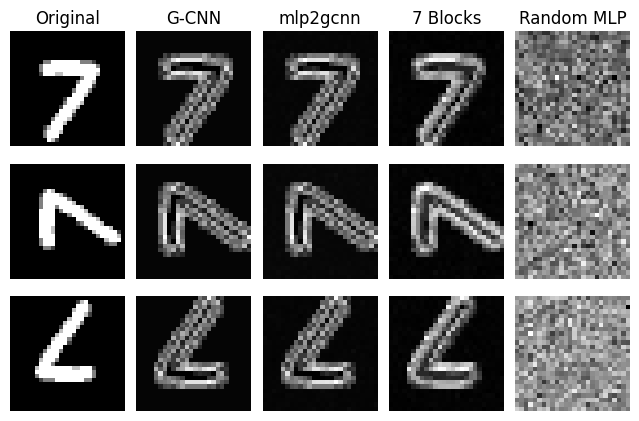

In [7]:
modelZ2.eval()
MLP_graph = nn.Linear(28*28, 26*26, bias=False).cuda()

train_loader, test_loader = prepare_dataset()
sample = next(iter(train_loader))
img = sample[0][0].cuda()
label = sample[0][1]

# img = torchvision.transforms.ToPILImage()(img)
# img.save("Input.png")

img = Image.open("Input.png")
img = torchvision.transforms.ToTensor()(img).cuda()

mlp_out = modelZ2(img, cparams_Z2).squeeze()
mlp_7_out = modelZ2_7(img, cparams_Z2).squeeze()
cnn_out = convZ2(img).squeeze(0)

result_cnn = torch.max(cnn_out, axis=0)[0].squeeze()
result_mlp = torch.max(mlp_out, axis=0)[0].squeeze()
result_mlp_7 = torch.max(mlp_7_out, axis=0)[0].squeeze()

# plot_results(mlp_out, cnn_out)
fig, axarr = plt.subplots(3, 5, figsize=(8, 5))
axarr[0, 0].imshow(img.squeeze().detach().cpu(), cmap='gray')
axarr[0, 0].axis("off")
axarr[0, 0].set_title("Original")

axarr[0, 1].imshow(result_cnn.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[0, 1].axis("off")
axarr[0, 1].set_title("G-CNN")

axarr[0, 2].imshow(result_mlp.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[0, 2].axis("off")
axarr[0, 2].set_title("mlp2gcnn")

axarr[0, 3].imshow(result_mlp_7.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[0, 3].axis("off")
axarr[0, 3].set_title("7 Blocks")

axarr[0, 4].imshow(MLP_graph(img.flatten()).reshape(26, 26).detach().cpu(), cmap='gray')
axarr[0, 4].axis("off")
axarr[0, 4].set_title("Random MLP")

rot_input_90 = rotate(img, 90)
mlp_out = modelZ2(rot_input_90, cparams_Z2).squeeze()
cnn_out = convZ2(rot_input_90).squeeze(0)
mlp_7_out = modelZ2_7(rot_input_90, cparams_Z2).squeeze()

result_cnn = torch.max(cnn_out, axis=0)[0].squeeze()
result_mlp = torch.max(mlp_out, axis=0)[0].squeeze()
result_mlp_7 = torch.max(mlp_7_out, axis=0)[0].squeeze()
axarr[1, 0].imshow(rot_input_90.squeeze().detach().cpu(), cmap='gray')
axarr[1, 0].axis("off")

axarr[1, 1].imshow(result_cnn.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[1, 1].axis("off")

axarr[1, 2].imshow(result_mlp.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[1, 2].axis("off")

axarr[1, 3].imshow(result_mlp_7.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[1, 3].axis("off")

axarr[1, 4].imshow(MLP_graph(rot_input_90.flatten()).reshape(26, 26).detach().cpu(), cmap='gray')
axarr[1, 4].axis("off")

rot_input_90 = rotate(rot_input_90, 90)
mlp_out = modelZ2(rot_input_90, cparams_Z2).squeeze()
cnn_out = convZ2(rot_input_90).squeeze(0)
mlp_7_out = modelZ2_7(rot_input_90, cparams_Z2).squeeze()

result_cnn = torch.max(cnn_out, axis=0)[0].squeeze()
result_mlp = torch.max(mlp_out, axis=0)[0].squeeze()
result_mlp_7 = torch.max(mlp_7_out, axis=0)[0].squeeze()
axarr[2, 0].imshow(rot_input_90.squeeze().detach().cpu(), cmap='gray')
axarr[2, 0].axis("off")

axarr[2, 1].imshow(result_cnn.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[2, 1].axis("off")

axarr[2, 2].imshow(result_mlp.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[2, 2].axis("off")

axarr[2, 3].imshow(result_mlp_7.reshape(26, 26).detach().cpu(), cmap='gray')
axarr[2, 3].axis("off")

axarr[2, 4].imshow(MLP_graph(rot_input_90.flatten()).reshape(26, 26).detach().cpu(), cmap='gray')
axarr[2, 4].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("Z2out.png")
plt.show()

torch.Size([26, 26])


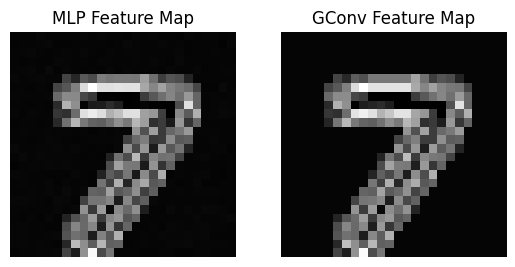

In [6]:
result_cnn = torch.max(cnn_out, axis=0)[0].squeeze()
result_mlp = torch.max(mlp_out, axis=0)[0].squeeze()
print(result_mlp.shape)
plt.subplot(1, 2, 1)
plt.imshow(result_mlp.reshape(26, 26).detach().cpu(), cmap='gray')
plt.title("MLP Feature Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_cnn.reshape(26, 26).detach().cpu(), cmap='gray')
plt.title("GConv Feature Map")
plt.axis("off")

plt.savefig("Z2_feature_map.png")
plt.show()

In [7]:
cfg = ConfigDict()
cfg.name = 'mlp2gcnn'
cfg.root_dir = "/project/a/aspuru/chengl43/rot_equiv_exp"
cfg.log_dir = f"{cfg.root_dir}/logs/"
# cfg.seed = 42 
cfg.seed = 10000
cfg.max_iters = 10000
cfg.grad_norm_clip = 1.0
cfg.lr = 1e-2
cfg.img_dim = 26
cfg.stride = 1
cfg.kernel_size = 3
cfg.ss_gamma = 2.0
cfg.bs = 1
cfg.activation = 0

cfg.in_dim = cfg.img_dim ** 2 
cfg.out_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.hidden_dim = 32
cfg.blocks = 9
cfg.layers = 1
cfg.block_output_dim = cnn_dim_out(cfg.img_dim, 3, 1, 0) ** 2
cfg.merge_dim = 10
cfg.provide_filter = 0
cfg.emb_dim = 20

cparams_P4 = torch.rand((1, 1, 4, 3, 3)).cuda()
modelP4 = fakeGCNN_P4(cfg).cuda()
convP4 = P4ConvP4(weight=cparams_P4)
checkpoint = torch.load("benchmark/checkpoints/9_26_P4_checkpoint.ckpt")
modelP4.load_state_dict(checkpoint['model'])

<All keys matched successfully>

torch.Size([1, 4, 576])
torch.Size([1, 4, 24, 24])
tensor(2.3362e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


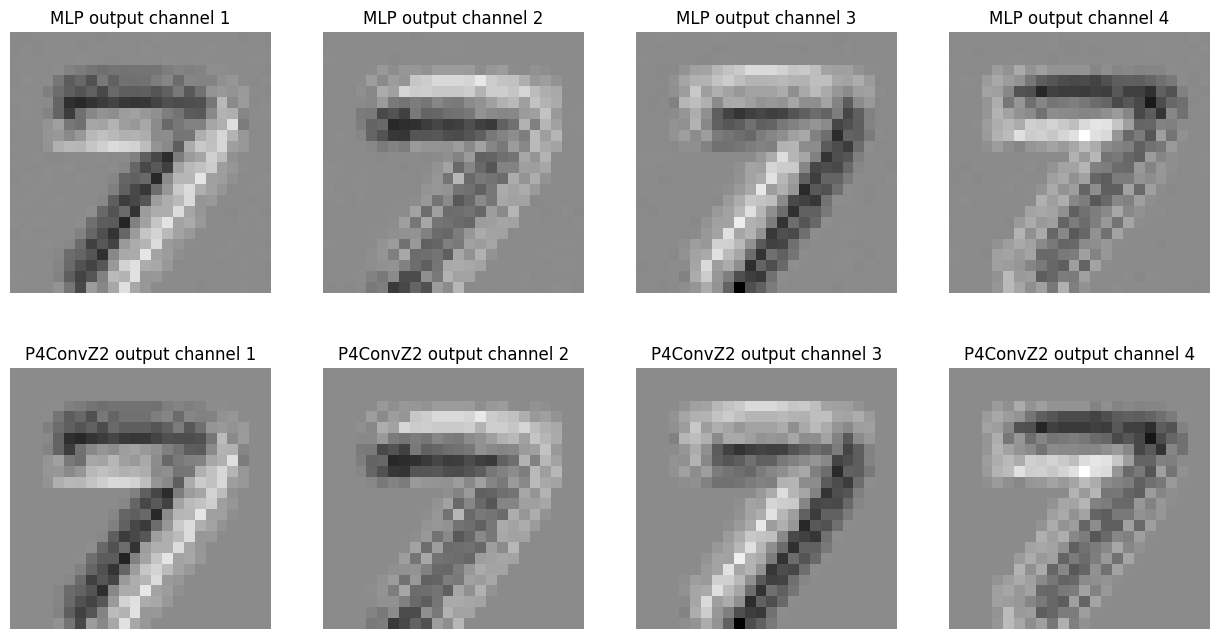

In [8]:

mlp_out_2 = modelP4(mlp_out.unsqueeze(0), cparams_P4.flatten())
cnn_out_2 = convP4(cnn_out.unsqueeze(0))
print(mlp_out_2.shape)
print(cnn_out_2.shape)
print(nn.MSELoss()(mlp_out_2.view(4, 24, 24), cnn_out_2.view(4, 24, 24)))

plot_results(mlp_out_2.view(4, 24, 24), cnn_out_2.view(4, 24, 24))
plt.savefig("P4out.png")
plt.show()

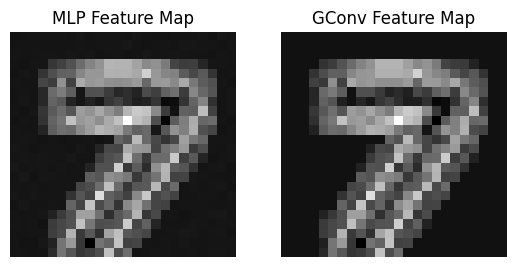

In [9]:
result_cnn = torch.max(cnn_out_2, axis=1)[0].squeeze()
result_mlp = torch.max(mlp_out_2, axis=1)[0].squeeze()

plt.subplot(1, 2, 1)
plt.imshow(result_mlp.reshape(24, 24).detach().cpu(), cmap='gray')
plt.title("MLP Feature Map")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_cnn.reshape(24, 24).detach().cpu(), cmap='gray')
plt.title("GConv Feature Map")
plt.axis("off")

plt.savefig("P4_feature_map.png")
plt.show()

In [10]:
from torchvision.transforms.functional import rotate

rot_input_90 = rotate(img, 90)
rot_input_180 = rotate(img, 180)
rot_input_270 = rotate(img, 270)
# images_np = np.array([img, rot_input_90, rot_input_180, rot_input_270])
images = torch.stack([img, rot_input_90, rot_input_180, rot_input_270]).cuda()
print(images.shape)

torch.Size([4, 1, 28, 28])


In [11]:
rot_output = modelP4(modelZ2(images, cparams_Z2), cparams_P4.flatten())
cnn_rot_output = convP4(convZ2(images))

mlp_result = torch.max(rot_output, axis=1)[0].reshape(4, 24, 24).detach().cpu()
cnn_result = torch.max(cnn_rot_output, axis=1)[0].reshape(4, 24, 24).detach().cpu()

f, axarr = plt.subplots(3, 4, figsize=(10, 6))

for i in range(4):
    axarr[0, i].imshow(images[i].squeeze().detach().cpu(), cmap='gray')
    axarr[0, i].axis('off')

for i in range(4):
    axarr[1, i].imshow(mlp_result[i].squeeze().detach().cpu(), cmap='gray')
    axarr[1, i].axis('off')

for i in range(4):
    axarr[2, i].imshow(cnn_result[i].squeeze().detach().cpu(), cmap='gray')
    axarr[2, i].axis('off')

# plt.subplots_adjust(left=0.05, right=0.8, wspace=0.1)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2704 and 676x576)

In [ ]:
rot_output = modelP4(modelZ2(rot_input, cparams_Z2).unsqueeze(0), cparams_P4.flatten())
cnn_rot_output = convP4(convZ2(rot_input))

plt.imshow(torch.sum(rot_output, axis=1).reshape(24, 24).detach().cpu(), cmap='gray')
plt.imshow(torch.sum(cnn_rot_output, axis=1).reshape(24, 24).detach().cpu(), cmap='gray')

plt.show()

NameError: name 'rot_input' is not defined

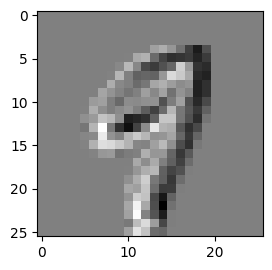

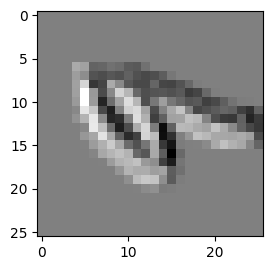

In [ ]:
conv_img = F.conv2d(img.reshape(1, 1, 28, 28), weight=cparams_Z2.reshape(1, 1, 3, 3))
rot_conv_img = F.conv2d(rot_input_90.reshape(1, 1, 28, 28), weight=cparams_Z2.reshape(1, 1, 3, 3))

plt.subplot(1, 2, 1)
plt.imshow(conv_img.squeeze().detach().cpu(), cmap='gray')
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(rot_conv_img.squeeze().detach().cpu(), cmap='gray')

plt.show()

tensor(15)
tensor(0)
tensor(4)
tensor(11)
tensor(19)
tensor(2)
tensor(1)
tensor(3)
tensor(1)


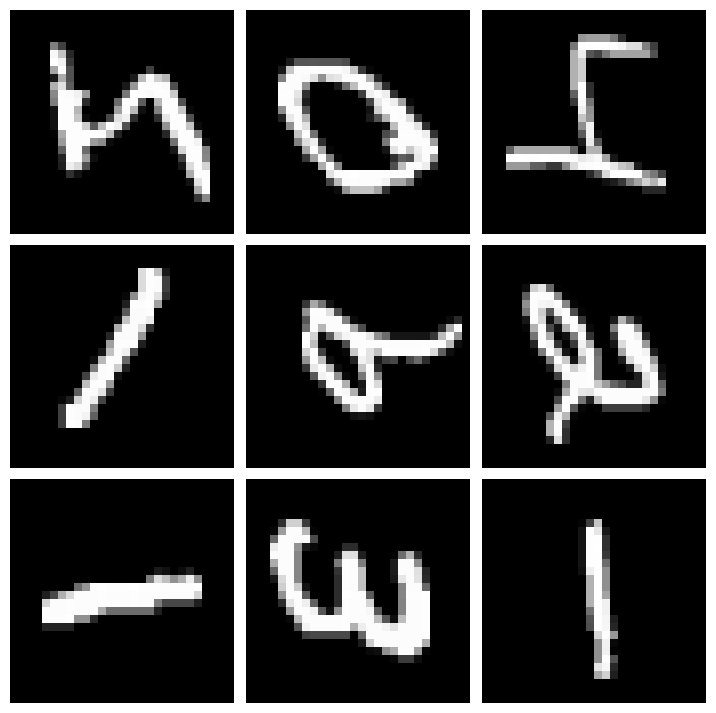

In [ ]:
class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, transform=transforms.ToTensor()):
        self.mnist = MNIST(root=root, train=train, download=False, transform=None)
        self.transform = transform

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        
        # Randomly translate the image
        direction = random.choice([0, 90, 180, 270])
        if direction == 0 or direction == 90:
            translated_img = transforms.functional.affine(img, angle=direction, translate=(0, 0), scale=1.0, shear=0)
            new_label = label
        else:
            translated_img = transforms.functional.affine(img, angle=direction, translate=(0, 0), scale=1.0, shear=0)
            new_label = label + 10  # Add 10 to the label to indicate translation to the right
        
        if self.transform is not None:
            translated_img = self.transform(translated_img)

        return translated_img, new_label

dataset = RotatedMNIST("benchmark/data")
dl = DataLoader(dataset, 10, False)
fig, axarr = plt.subplots(3, 3, figsize=(9, 9))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for i in range(9):
    batch = next(iter(dl))
    print(batch[1][i])
    axarr[i//3, i%3].imshow(batch[0][i].squeeze().detach().cpu(), cmap='gray')
    axarr[i//3, i%3].axis("off")

fig.show()
fig.savefig("RotDatasetVisualizaiton.png")

tensor(5)
tensor(0)
tensor(4)
tensor(1)
tensor(9)
tensor(2)
tensor(1)
tensor(3)
tensor(1)


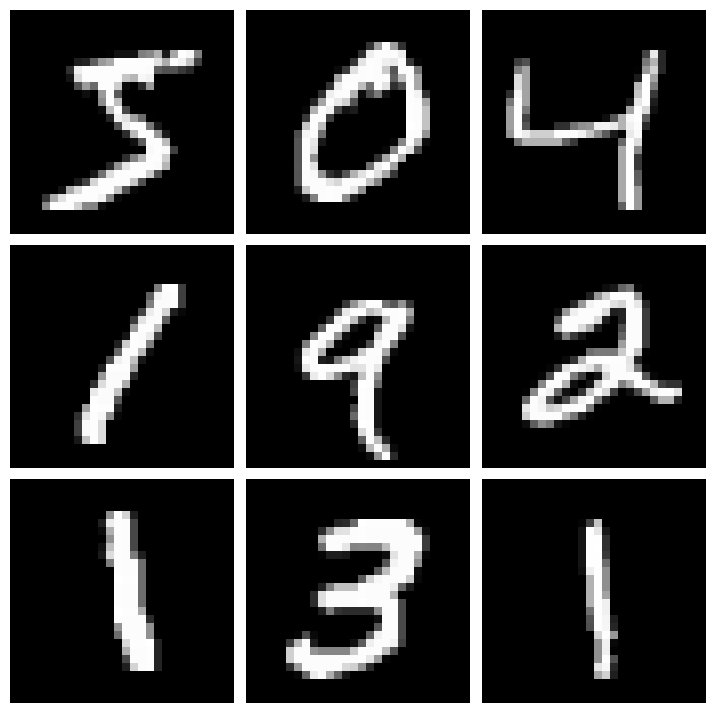

In [4]:
dataset = MNIST("benchmark/data", transform=ToTensor())
dl = DataLoader(dataset, 10, False)
fig, axarr = plt.subplots(3, 3, figsize=(9, 9))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for i in range(9):
    batch = next(iter(dl))
    print(batch[1][i])
    axarr[i//3, i%3].imshow(batch[0][i].squeeze().detach().cpu(), cmap='gray')
    axarr[i//3, i%3].axis("off")

fig.show()
fig.savefig("MNISTVisualization.png")

tensor(15)


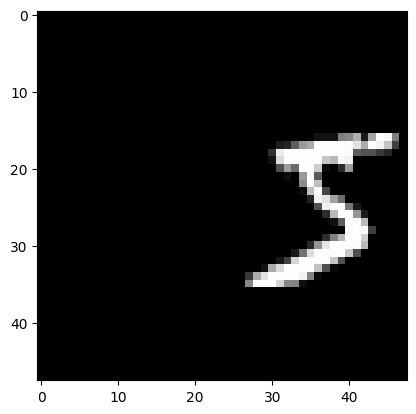

In [ ]:
class TranslatedMNIST(Dataset):
    def __init__(self, root, train=True, transform=transforms.ToTensor()):
        self.mnist = MNIST(root=root, train=train, download=False, transform=None)
        self.transform = transform
        self.pad_transform = transforms.Pad((10, 10, 10, 10))  # Padding to make 48x48 images

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        img = self.pad_transform(img)  # Pad the image to 48x48
        
        # Randomly translate the image
        direction = random.choice(['left', 'right'])
        if direction == 'left':
            translation = random.randint(5, 15)  # Original 
            trans_y = random.randint(0, 15)
            translated_img = transforms.functional.affine(img, angle=0, translate=(-translation, trans_y), scale=1.0, shear=0)
            new_label = label
        else:
            translation = random.randint(5, 15)
            trans_y = random.randint(0, 15)
            translated_img = transforms.functional.affine(img, angle=0, translate=(translation, trans_y), scale=1.0, shear=0)
            new_label = label + 10  
        
        if self.transform is not None:
            translated_img = self.transform(translated_img)

        return translated_img, new_label
    
dataset = TranslatedMNIST("benchmark/data")
dl = DataLoader(dataset, 10, False)
i = 0
batch = next(iter(dl))
print(batch[1][i])
plt.imshow(batch[0][i].squeeze().detach().cpu(), cmap='gray')
plt.show()